In [230]:
from pathlib import Path
import pickle
from collections import namedtuple, defaultdict
from functools import partial
from itertools import chain

import pandas as pd
import networkx as nx

In [128]:
def read_mmseqs_search_output(fn: str, usecols: str = 'query,target,pident,qcov,tcov') -> pd.DataFrame:
    header = 'query,target,pident,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov'.split(',')
    return (
        pd.read_csv(
            fn,
            sep='\t',
            header=None,
            names=header,
            usecols=usecols.split(','),
        )
    )

def get_graph_description(G):
    return {
        'number_of_nodes': G.number_of_nodes(),
        'number_of_edges': G.number_of_edges(),
        # 'number_of_connected_components': nx.number_connected_components(G),
        # 'average_clustering': nx.average_clustering(G),
        # 'average_shortest_path_length': nx.average_shortest_path_length(G),
    }


In [20]:
root_dir = Path('../../').resolve()

In [27]:
ge_pident = 0.3
ge_qcov = 0.8
ge_tcov = 0.8


systems = (
    read_mmseqs_search_output(root_dir / '.test/network/query_vs_target.tsv')
    .loc[
        lambda df_: df_.pident.ge(ge_pident) & df_.qcov.ge(ge_qcov) & df_.tcov.ge(ge_tcov),
        ['query', 'target']
    ]
    .pipe(
        lambda df_: pd.DataFrame(
            data=df_.target.values,
            index=pd.MultiIndex.from_tuples(df_['query'].apply(lambda x: x.split('-')), names=['system', 'component']),
            columns=['target']
        )
    )
    .groupby(['system', 'component'])
    .agg(set)
)

systems.head()

target
system component                                                   
DS4    1          {WP_182794943.1, WP_184596389.1, WP_217277010....
       2          {WP_105397593.1, WP_054578447.1, WP_169712990....

In [25]:
# read network from pickle
def read_network_from_pickle(fn: str) -> nx.Graph:
    with open(fn, 'rb') as f:
        return pickle.load(f)
    
EdgeInfo = namedtuple('EdgeInfo', ['on_contig_position', 'assembly', 'contig'])

G = read_network_from_pickle(root_dir / '.test/network/all_cds.graph.with_oncontig_pos.pickle')

print(f'Number of nodes: {G.number_of_nodes():,}')
print(f'Number of edges: {G.number_of_edges():,}')

Number of nodes: 10,455,255
Number of edges: 13,549,262


In [11]:
def get_subgraph(G, start_nodes, n_edges=5):
    """ Returns a subgraph of G with n_edges of distance from start_nodes """
    connected_nodes = set()
    for node in start_nodes:
        connected_nodes.update(nx.ego_graph(G, node, radius=n_edges).nodes())
    
    return G.subgraph(connected_nodes)




../../.test/network/all_cds.graph.with_oncontig_pos.pickle


In [150]:
def query_network(G, query_node, radius):
    try:
        return set(nx.ego_graph(G, query_node, radius=radius).nodes())
    except nx.exception.NodeNotFound:
        return set()

query_radius = 5
query_network = partial(query_network, G, radius=query_radius)

windows = (
    systems
    .explode('target')
    .groupby(['system', 'component'])
    .head(2)
    .assign(
        close_nodes = lambda df_: df_.target.apply(query_network),
    )
)

windows

target  \
system component                   
DS4    1          WP_182794943.1   
       1          WP_184596389.1   
       2          WP_105397593.1   
       2          WP_054578447.1   

                                                        close_nodes  
system component                                                     
DS4    1          {WP_255860578.1, WP_099031218.1, WP_259399240....  
       1          {WP_238826164.1, WP_139323093.1, WP_208214190....  
       2          {WP_139323093.1, WP_207220454.1, WP_233499631....  
       2          {WP_155490559.1, WP_155490557.1, WP_054578444....

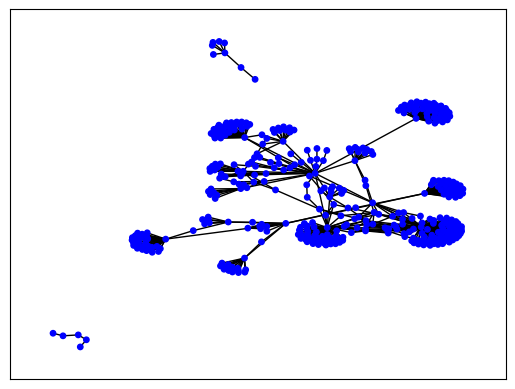

In [134]:
def plot_subgraph(subgraph, seeds, node_size=15, random_state=42):

    node_colors = ['r' if node in seeds else 'b' for node in subgraph.nodes()]

    pos = nx.spring_layout(subgraph, seed=random_state)

    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color=node_colors)
    nx.draw_networkx_edges(subgraph, pos)
    # nx.draw_networkx_labels(subgraph, pos, font_size=8)


subgraph = G.subgraph(chain.from_iterable(windows.close_nodes))

plot_subgraph(subgraph, chain.from_iterable(windows.target.unique()))

In [151]:
g = G.subgraph(set(chain.from_iterable(windows.close_nodes)))
get_graph_description(g)

{'number_of_nodes': 231173, 'number_of_edges': 549157}

In [374]:
def get_node_info(G, node):
    return G.nodes(data=True)[node]['info']

get_node_info = partial(get_node_info, G)

def get_edge_info(G, edge):
    return G.edges(data=True)[edge]['info']

get_edge_info = partial(get_edge_info, G)


def extract_edge_info(G):
    data = defaultdict(list)

    for edge in G.edges(data=True):
        source, target, infos = edge
        for info in infos['info']:
            oncontig_pos, assembly, contig = info
            data[(assembly, contig)].append((source, target, oncontig_pos))

    for (assembly, contig), infos in data.items():
        yield assembly, contig, infos
    
def format_edge_info(edge_info):
    return (
        pd.DataFrame(
            data=edge_info[2],
            columns=['gsource', 'gtarget', 'on_contig_position'],
        )
        .sort_values('on_contig_position')
        .assign(
            windows = lambda df_: df_.on_contig_position.diff().ne(1).cumsum(),
            assembly = edge_info[0],
            contig = edge_info[1],
        )
        .groupby(['assembly', 'contig', 'windows'])
        .apply(lambda df_:
            set(chain.from_iterable(df_[['gsource', 'gtarget']].values))
        )
        .rename('nodes')
        .reset_index()
    )

positive_matches = set(windows.target)

edge_infos = extract_edge_info(g)

remove_contigs_without_matches = filter(
        lambda tup: set(chain.from_iterable((i[:2] for i in tup[2]))) & positive_matches,
        edge_infos
)

as_dfs = map(format_edge_info, remove_contigs_without_matches)


all_positive_windows = (
    pd.concat(
        as_dfs,
        ignore_index=True,
    )
    .loc[lambda df_: df_.nodes.apply(lambda x: bool(x & positive_matches))]
    .reset_index(drop=True)
)

print(all_positive_windows.shape)
all_positive_windows.head()

(429, 4)


,assembly,contig,windows,nodes
0,GCF_006239335.1,NZ_SBIJ01000014.1,1,"{WP_217277010.1, WP_105397593.1, WP_139655662...."
1,GCF_015354575.1,NZ_JACAFQ010000022.1,1,"{WP_184596389.1, WP_194790738.1, WP_141231084...."
2,GCF_001655295.1,NZ_CP011525.1,8,"{WP_184596389.1, WP_234228493.1, WP_102619986...."
3,GCF_018388545.1,NZ_CP074412.1,4,"{WP_156088655.1, WP_161469356.1, WP_122455541...."
4,GCF_014190825.1,NZ_JACHVR010000001.1,2,"{WP_101220798.1, WP_155954677.1, WP_028941239...."


In [362]:
all_positive_windows.nodes & {'WP_105397593.1'}

0       True
1      False
9      False
21     False
23     False
       ...  
586    False
587    False
588    False
590    False
591    False
Name: nodes, Length: 429, dtype: bool

In [431]:
def split_col_to_multiindex(df, sep='-', names=None):
    df.columns = pd.MultiIndex.from_tuples(df.columns.to_series().str.split(sep).apply(tuple), names=names)
    return df
    



prep_freq = (
    systems
    .assign(
        merged_index = lambda df_: df_.index.to_series().apply(lambda x: '-'.join(x)),
    )
    .set_index('merged_index')
    .pipe(
        lambda df_: pd.DataFrame(
            data=zip(*map(lambda x: all_positive_windows.nodes.apply(lambda y: bool(x & y)), df_.target)),
            # data=zip(*map(lambda x: all_positive_windows.nodes.apply(lambda y: x & y), df_.target)),
            columns=df_.index.values,
        )
    )
    .pipe(
        lambda df_: pd.concat([all_positive_windows, df_], axis=1)
    )
    .drop('nodes', axis=1)
    .set_index(['assembly', 'contig', 'windows'])
    .pipe(split_col_to_multiindex, names=['system', 'component'])
)


def head(df, n=5):
    """
    Mostra o número de linhas, colunas
    e os tipos dos dados
    """
    print(f'Number of rows: {df.shape[0]:,}')
    print(f'Number of columns: {df.shape[1]:,}')
    print('\n', df.dtypes, sep='\n')
    
    return df.iloc[:n]

pd.DataFrame.head = head # <-- Substitui o head() do pandas 
                         #     por um que mostra o número de linhas,
                         #     colunas e os tipos dos dados.

prep_freq.head() # <- Pronto agora é só usar head() normalmente /o/. 

Number of rows: 429
Number of columns: 2


system  component
DS4     1            bool
        2            bool
dtype: object


system                                         DS4      
component                                        1     2
assembly        contig               windows            
GCF_006239335.1 NZ_SBIJ01000014.1    1        True  True
GCF_015354575.1 NZ_JACAFQ010000022.1 1        True  True
GCF_001655295.1 NZ_CP011525.1        8        True  True
GCF_018388545.1 NZ_CP074412.1        4        True  True
GCF_014190825.1 NZ_JACHVR010000001.1 2        True  True

In [ ]:

pd.DataFrame.head = head

prep_freq.head()

In [414]:
oi = temp.loc[pd.IndexSlice['GCF_006239335.1', :, :]]

# subgraph = G.subgraph(oi.nodes[0])
# plot_subgraph(subgraph, tuple(chain.from_iterable(oi.iloc[0, 1:].values)))

temp


,,,nodes,DS4-1,DS4-2
assembly,contig,windows,,,
GCF_006239335.1,NZ_SBIJ01000014.1,1,"{WP_217277010.1, WP_105397593.1, WP_139655662....",{WP_217277010.1},{WP_105397593.1}
GCF_015354575.1,NZ_JACAFQ010000022.1,1,"{WP_184596389.1, WP_194790738.1, WP_141231084....",{WP_184596389.1},{WP_027915645.1}
GCF_001655295.1,NZ_CP011525.1,8,"{WP_184596389.1, WP_234228493.1, WP_102619986....",{WP_184596389.1},{WP_027915645.1}
GCF_018388545.1,NZ_CP074412.1,4,"{WP_156088655.1, WP_161469356.1, WP_122455541....",{WP_184596389.1},{WP_027915645.1}
GCF_014190825.1,NZ_JACHVR010000001.1,2,"{WP_101220798.1, WP_155954677.1, WP_028941239....",{WP_184596389.1},{WP_027915645.1}
...,...,...,...,...,...
GCF_017582585.1,NZ_JAGFDU010000005.1,1,"{WP_184596389.1, WP_229980162.1, WP_069016948....",{WP_184596389.1},{WP_027915645.1}
GCF_002797475.1,NZ_PESJ01000024.1,1,"{WP_229980162.1, WP_184596389.1, WP_069016948....",{WP_184596389.1},{WP_027915645.1}
GCF_001642705.1,NZ_LWBV01000009.1,1,"{WP_184596389.1, WP_063914670.1, WP_102682613....",{WP_184596389.1},{WP_027915645.1}


In [180]:


# df.sort_values('on_contig_position')
#     # find windows of direct neighbors
#     .assign(
#         window = lambda df_: df_.on_contig_position.diff().ne(1).cumsum(),
#     )
#     .groupby(['assembly', 'contig', 'window'])
#     # aggregate gsources and gtargets into sets then merge them
#     .agg({'gsource': set, 'gtarget': set}) 
#     .agg(lambda x: set(chain.from_iterable(x)), axis=1)
#     .rename('nodes')
#     .loc[lambda s_: (s_ & positive_matches) ]
#     .to_frame()


for i, df in edge_info.groupby(['assembly', 'contig']):
    if set(chain.from_iterable(df[['gsource', 'gtarget']].values)) & positive_matches:
        break

GCF_000219605.1
NC_015740.1


In [162]:
i[1].sort_values('on_contig_position')

,gsource,gtarget,on_contig_position,assembly,contig
1390152,WP_001393555.1,WP_236313314.1,56,GCF_000005845.2,NC_000913.3
2404088,WP_236313314.1,WP_236637254.1,57,GCF_000005845.2,NC_000913.3
1183966,WP_249940713.1,WP_240266445.1,251,GCF_000005845.2,NC_000913.3
1183967,WP_249940713.1,WP_229020674.1,252,GCF_000005845.2,NC_000913.3
2782038,WP_255429653.1,WP_239636933.1,286,GCF_000005845.2,NC_000913.3
654824,WP_000878218.1,WP_255429653.1,287,GCF_000005845.2,NC_000913.3
2015228,WP_000567766.1,NP_416500.1,345,GCF_000005845.2,NC_000913.3
2009631,WP_201602110.1,WP_241226007.1,543,GCF_000005845.2,NC_000913.3
2009633,WP_201602110.1,WP_159204656.1,544,GCF_000005845.2,NC_000913.3
1993591,WP_137762709.1,WP_134688681.1,582,GCF_000005845.2,NC_000913.3


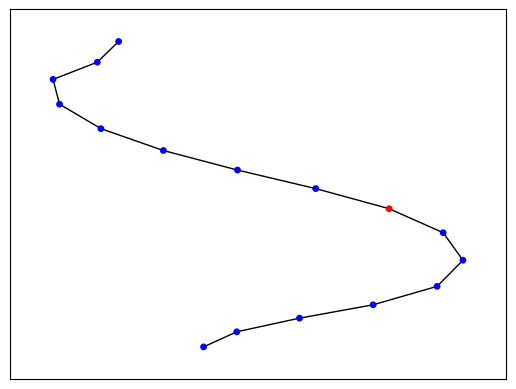

In [213]:
t = nx.Graph()
t.add_edges_from(oi[['gsource', 'gtarget']].values)

pos = nx.spring_layout(t, seed=42)

# nx.draw(t, pos, node_size=15, node_color='b')

plot_subgraph(t, windows.target.unique(), node_size=15)

In [225]:
(
    df.sort_values('on_contig_position')
    # find windows of direct neighbors
    .assign(
        window = lambda df_: df_.on_contig_position.diff().ne(1).cumsum(),
    )
    .groupby(['assembly', 'contig', 'window'])
    # aggregate gsources and gtargets into sets then merge them
    .agg({'gsource': set, 'gtarget': set}) 
    .agg(lambda x: set(chain.from_iterable(x)), axis=1)
    .rename('nodes')
    .loc[lambda s_: (s_ & positive_matches) ]
    .to_frame()
)

,,,nodes
assembly,contig,window,
GCF_000219605.1,NC_015740.1,4,"{WP_184596389.1, WP_226687507.1, WP_013983944...."
